In [101]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import pandas as pd
import os

M0 = 1440 #mT
shape = [3*25.4/16, 25.4/8] #diameter and height
x0 = np.array([0,0,10, 0,0,1])


In [102]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

In [103]:
folder = os.path.join('..', './MLX07172024_D32N52_AboutZ_5mm7')
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [104]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [105]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[ 0.38679576, -3.91748862, 12.7829972 ,  0.04923642,  0.02854382,
         0.9983792 ],
       [ 2.85931699, -3.89068423, 12.76560426,  0.06320182,  0.03141801,
         0.99750611],
       [ 5.09111588, -2.52008775, 12.76734677,  0.08675024,  0.06217237,
         0.99428818],
       [ 6.35852496, -0.24978935, 12.77148418,  0.09844491,  0.07934816,
         0.99197403],
       [ 6.29676763,  2.16243948, 12.79286158,  0.08994545,  0.0693181 ,
         0.99353149],
       [ 4.95132342,  4.34740057, 12.81334265,  0.07821633,  0.06420896,
         0.99486653],
       [ 2.86508591,  5.50967508, 12.82907022,  0.07294647,  0.07036561,
         0.99485049],
       [ 0.34027321,  5.57458363, 12.83303259,  0.07600965,  0.07677689,
         0.99414679],
       [-1.71927906,  4.24089156, 12.84751864,  0.07179365,  0.07042009,
         0.99493049],
       [-3.02238365,  2.02300143, 12.84906147,  0.05916635,  0.05501447,
         0.99673103],
       [-3.05637968, -0.46271187, 12.828484  ,  0.

In [106]:
print(loc_pred)

[[ 0.38679576 -3.91748862 12.7829972 ]
 [ 2.85931699 -3.89068423 12.76560426]
 [ 5.09111588 -2.52008775 12.76734677]
 [ 6.35852496 -0.24978935 12.77148418]
 [ 6.29676763  2.16243948 12.79286158]
 [ 4.95132342  4.34740057 12.81334265]
 [ 2.86508591  5.50967508 12.82907022]
 [ 0.34027321  5.57458363 12.83303259]
 [-1.71927906  4.24089156 12.84751864]
 [-3.02238365  2.02300143 12.84906147]
 [-3.05637968 -0.46271187 12.828484  ]
 [-1.89333292 -2.5692364  12.8109377 ]
 [ 0.35900437 -3.90690825 12.78698909]]


In [107]:
gamma_file = r'C:\Users\Brandon Nguyen\OneDrive\Watanabe_Project\HDMM_05012024.xlsx'
df = pd.read_excel(gamma_file)
print(df)
hdmm_x = df.loc[0:, 'x']
hdmm_y = df.loc[0:, 'y']
hdmm_z = df.loc[0:, 'z']
hdmm_disp = df.loc[0:, 'HDMM [mm]']

    Unnamed: 0  x  y  z  HDMM [mm]    d [mm]  error [mm]  Unnamed: 7  x.1  \
0            1  0  0  0      0.030  0.000000    0.030000           1    0   
1            2  0  1  0      1.030  1.000000    0.030000           2    0   
2            3  0  2  0      2.030  2.000000    0.030000           3    0   
3            4  0  3  0      3.030  3.000000    0.030000           4    0   
4            5  0  4  0      4.020  4.000000    0.020000           5    0   
5            6  0  5  0      5.020  5.000000    0.020000           6    0   
6            7  1  0  0      1.030  1.000000    0.030000           7    1   
7            8  1  1  0      1.350  1.414214   -0.064214           8    1   
8            9  1  2  0      2.250  2.236068    0.013932           9    1   
9           10  1  3  0      3.150  3.162278   -0.012278          10    1   
10          11  1  4  0      4.120  4.123106   -0.003106          11    1   
11          12  1  5  0      5.110  5.099020    0.010980          12    1   

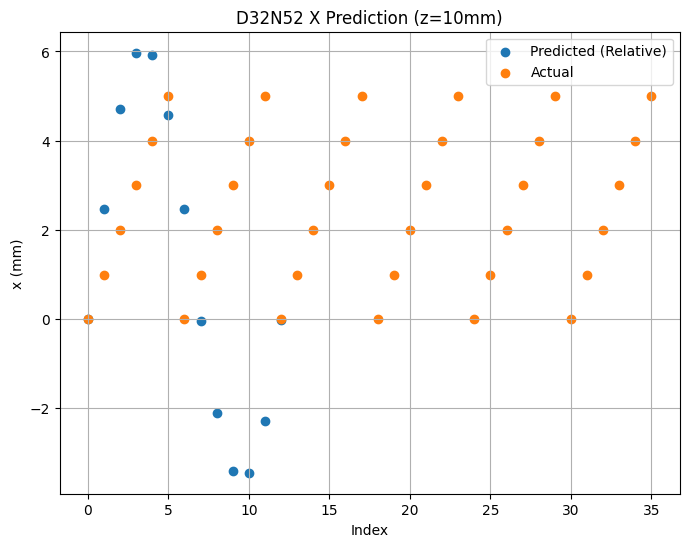

In [108]:
rel_loc_predx = [x - loc_pred[0,0] for x in loc_pred[:,0]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), rel_loc_predx, label='Predicted (Relative)')
plt.scatter(list(range(len(hdmm_x))), hdmm_y, label='Actual')
plt.xlabel('Index')
plt.ylabel('x (mm)')
plt.title('D32N52 X Prediction (z=10mm)')
plt.legend()
plt.grid(True)
plt.show()

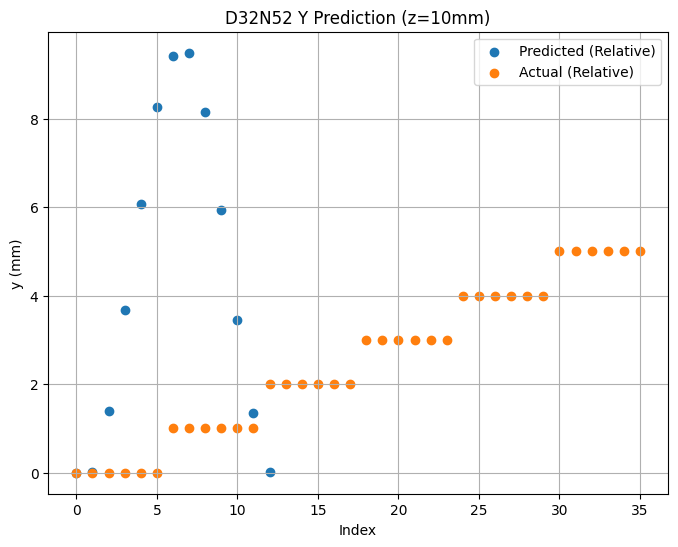

In [109]:
rel_loc_predy = [x - loc_pred[0,1] for x in loc_pred[:,1]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predy))), rel_loc_predy, label='Predicted (Relative)')
plt.scatter(list(range(len(hdmm_x))), hdmm_x, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('y (mm)')
plt.title('D32N52 Y Prediction (z=10mm)')
plt.legend()
plt.grid(True)
plt.show()

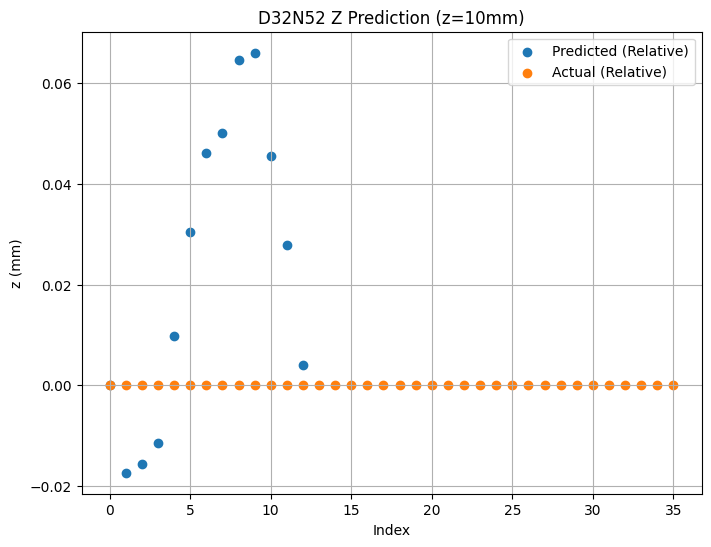

In [110]:
rel_loc_predz = [x - loc_pred[0,2] for x in loc_pred[:,2]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predz))), rel_loc_predz, label='Predicted (Relative)')
plt.scatter(list(range(len(hdmm_z))), hdmm_z, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('z (mm)')
plt.title('D32N52 Z Prediction (z=10mm)')
plt.legend()
plt.grid(True)
plt.show()

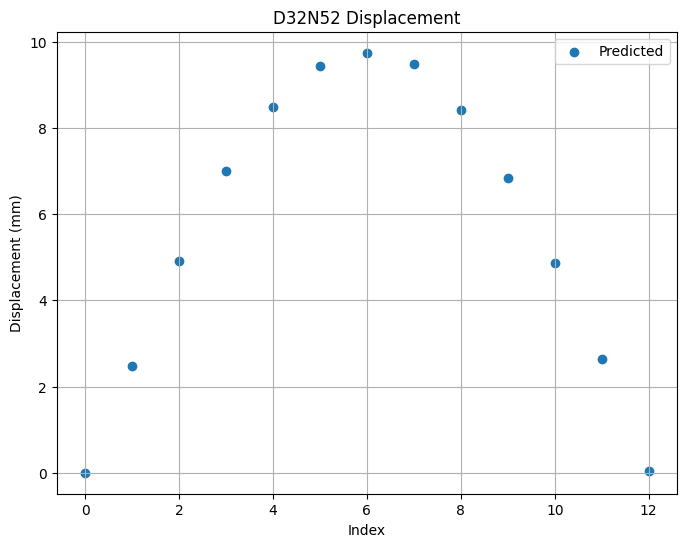

In [111]:
dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

#diff = np.array(hdmm_disp) - disp
#print(max(diff))

plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), disp, label='Predicted')
#plt.scatter(list(range(len(hdmm_z))), hdmm_disp, label='Actual')
plt.xlabel('Index')
plt.ylabel('Displacement (mm)')
plt.title('D32N52 Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
import plotly.graph_objects as go
a = 0
b = 1

measured2D = go.Scatter(x=loc_pred[:,a], y=loc_pred[:,b], mode='markers')
layout = go.Layout(title='x vs y (measured)')
fig2 = go.Figure(data=[measured2D], layout=layout)
fig2.update_layout(
    xaxis_title="x [mm]",
    yaxis_title="y [mm]"
)
fig2.update_yaxes(scaleanchor='x')
fig2.show()

print(loc_pred)
print(angle_pred)

[[ 0.38679576 -3.91748862 12.7829972 ]
 [ 2.85931699 -3.89068423 12.76560426]
 [ 5.09111588 -2.52008775 12.76734677]
 [ 6.35852496 -0.24978935 12.77148418]
 [ 6.29676763  2.16243948 12.79286158]
 [ 4.95132342  4.34740057 12.81334265]
 [ 2.86508591  5.50967508 12.82907022]
 [ 0.34027321  5.57458363 12.83303259]
 [-1.71927906  4.24089156 12.84751864]
 [-3.02238365  2.02300143 12.84906147]
 [-3.05637968 -0.46271187 12.828484  ]
 [-1.89333292 -2.5692364  12.8109377 ]
 [ 0.35900437 -3.90690825 12.78698909]]
[[0.04923642 0.02854382 0.9983792 ]
 [0.06320182 0.03141801 0.99750611]
 [0.08675024 0.06217237 0.99428818]
 [0.09844491 0.07934816 0.99197403]
 [0.08994545 0.0693181  0.99353149]
 [0.07821633 0.06420896 0.99486653]
 [0.07294647 0.07036561 0.99485049]
 [0.07600965 0.07677689 0.99414679]
 [0.07179365 0.07042009 0.99493049]
 [0.05916635 0.05501447 0.99673103]
 [0.0431088  0.04972106 0.99783237]
 [0.03725863 0.04456426 0.99831148]
 [0.04887531 0.0291599  0.99837914]]
